In [24]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import least_squares
from skimage.measure import EllipseModel
import os 
from scipy.spatial import ConvexHull

def ellipse_residuals(params, x, y):
    xc, yc, a, b, theta = params
    cos_theta = np.cos(theta)
    sin_theta = np.sin(theta)
    
    x_rot = (x - xc) * cos_theta + (y - yc) * sin_theta
    y_rot = -(x - xc) * sin_theta + (y - yc) * cos_theta
    
    return ((x_rot / a) ** 2 + (y_rot / b) ** 2) - 1

def fit_ellipse(x, y):
    x_m = np.mean(x)
    y_m = np.mean(y)
    a0 = (max(x) - min(x)) / 2
    b0 = (max(y) - min(y)) / 2
    theta0 = 0
    
    initial_guess = [x_m, y_m, a0, b0, theta0]
    
    result = least_squares(ellipse_residuals, initial_guess, args=(x, y))
    
    return result.x

def plot_ellipse(params, ax=None, **kwargs):
    xc, yc, a, b, theta = params
    t = np.linspace(0, 2 * np.pi, 100)
    
    ellipse_x = xc + a * np.cos(t) * np.cos(theta) - b * np.sin(t) * np.sin(theta)
    ellipse_y = yc + a * np.cos(t) * np.sin(theta) + b * np.sin(t) * np.cos(theta)
    
    if ax is None:
        ax = plt.gca()
    
    ax.plot(ellipse_x, ellipse_y, **kwargs)
    ax.set_aspect('equal')

def calculate_residuals(points, xc, yc, a, b, theta):
    cos_angle = np.cos(theta)
    sin_angle = np.sin(theta)
    
    x_rot = (points[:, 1] - xc) * cos_angle + (points[:, 0] - yc) * sin_angle
    y_rot = -(points[:, 1] - xc) * sin_angle + (points[:, 0] - yc) * cos_angle
    ellipse_equation = (x_rot / a) ** 2 + (y_rot / b) ** 2 - 1
    
    residuals = np.abs(ellipse_equation)
    return np.mean(residuals)

Kernel (3, 3), Sigma 0, Thresholds (10, 20): Residual = 0.3490


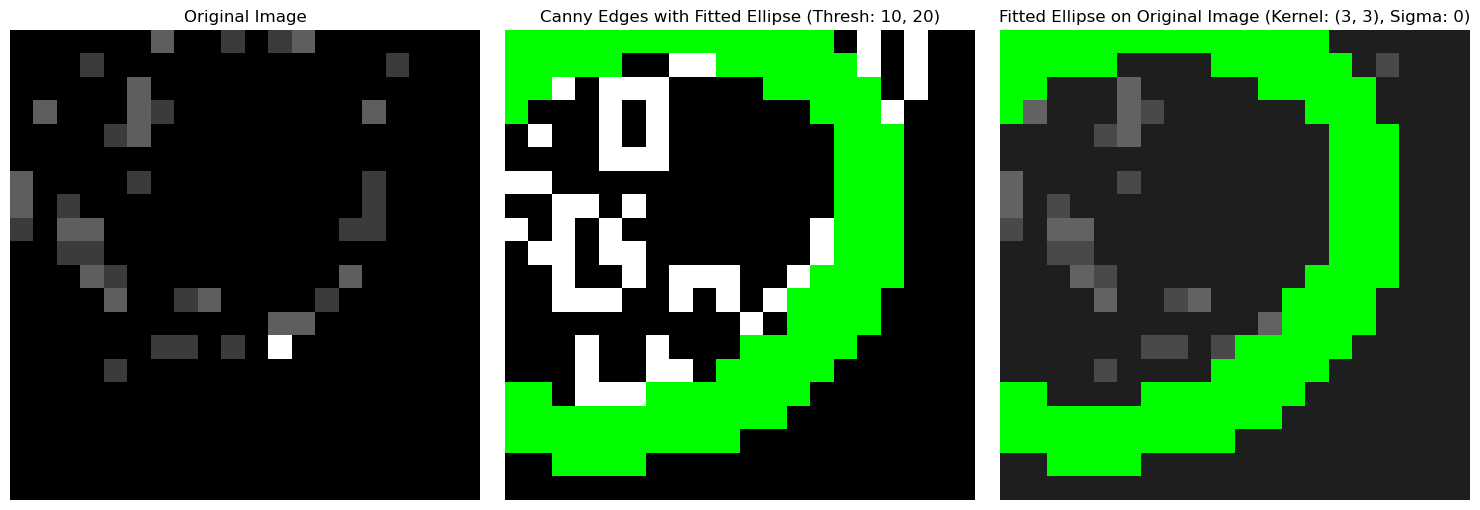

Kernel (3, 3), Sigma 0, Thresholds (10, 50): Residual = 0.3490


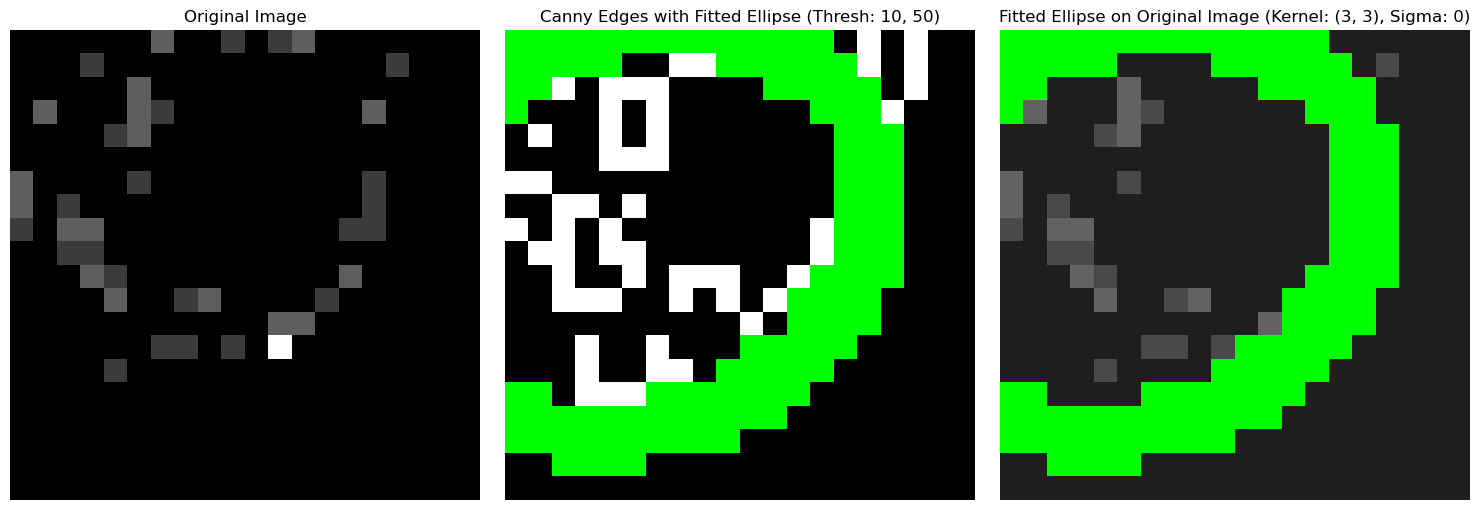

Kernel (3, 3), Sigma 0, Thresholds (50, 100): Residual = 0.2711


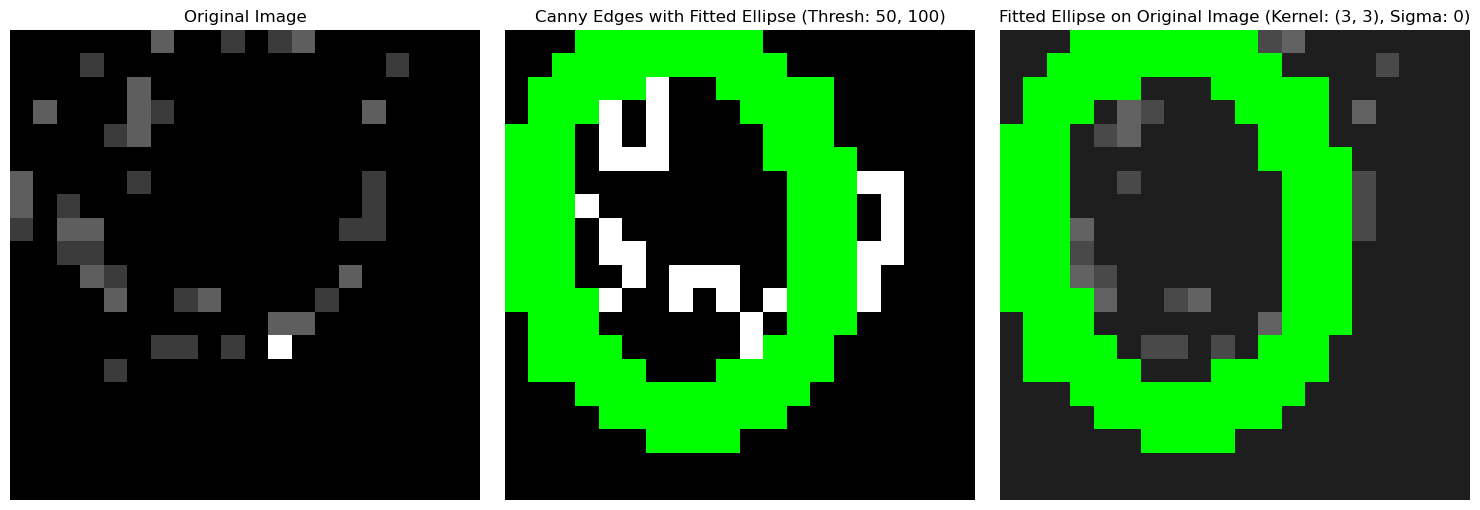

Kernel (5, 5), Sigma 0, Thresholds (10, 20): Residual = 0.3496


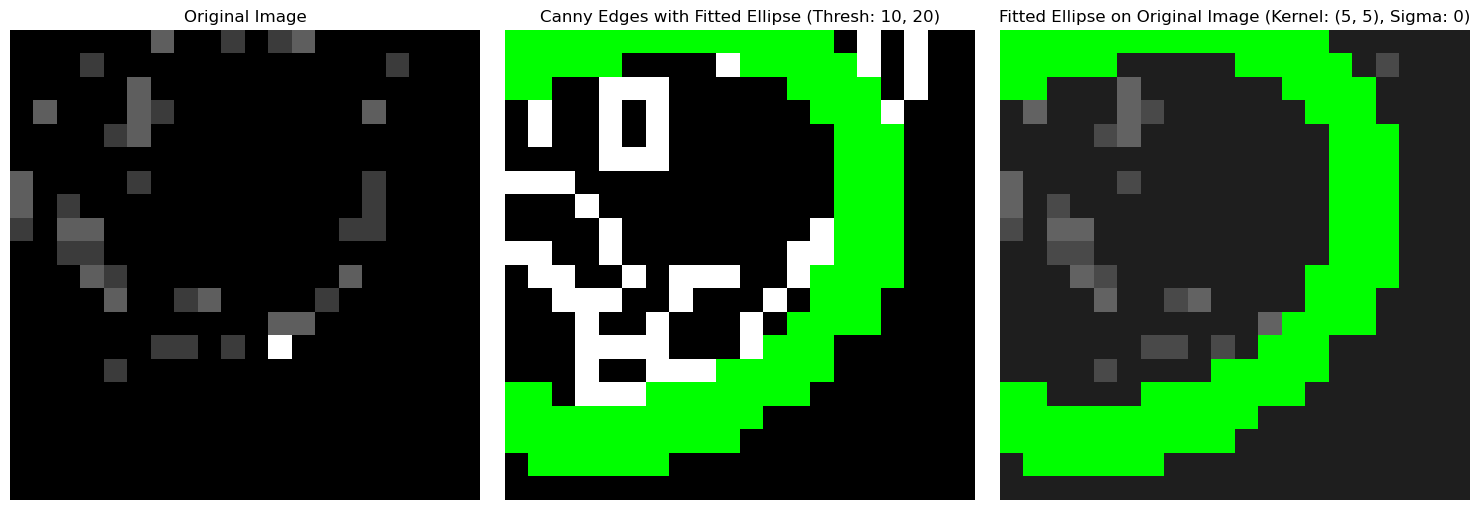

Kernel (5, 5), Sigma 0, Thresholds (10, 50): Residual = 0.3114


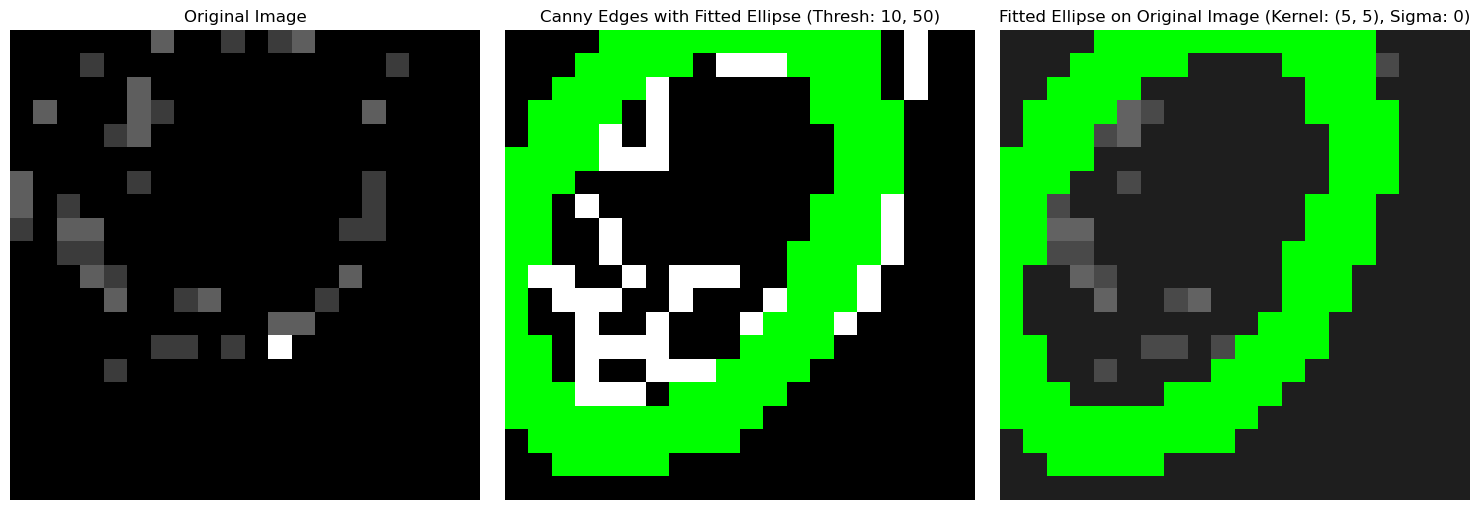

Kernel (5, 5), Sigma 0, Thresholds (50, 100): Residual = 0.4380


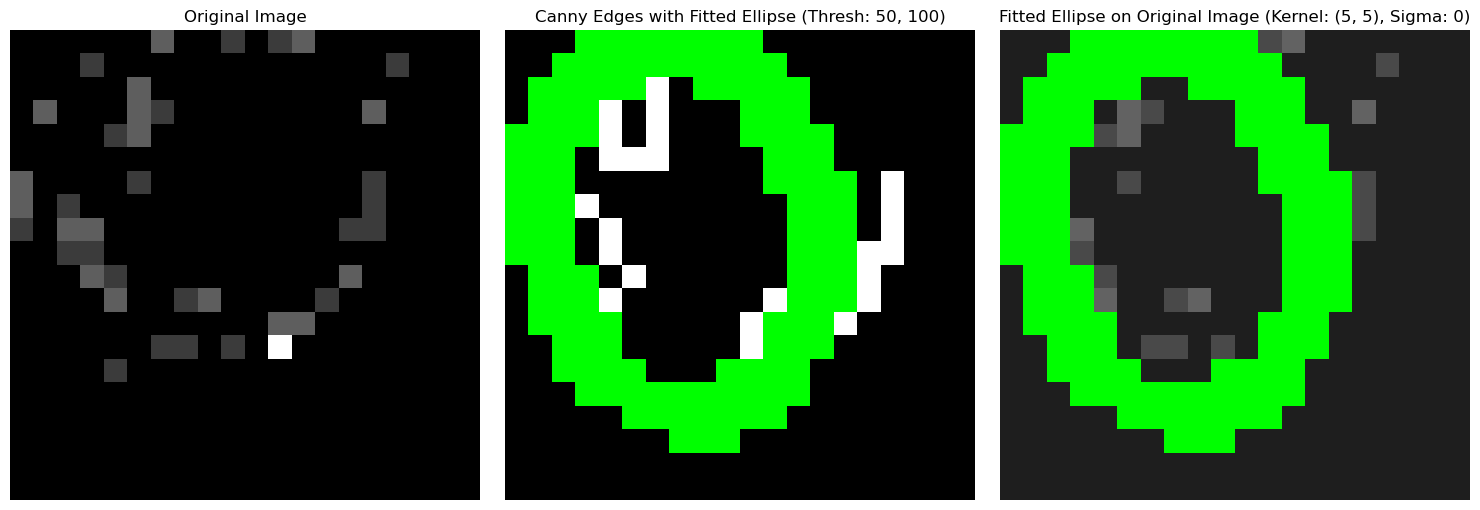

Kernel (7, 7), Sigma 0, Thresholds (10, 20): Residual = 0.5254


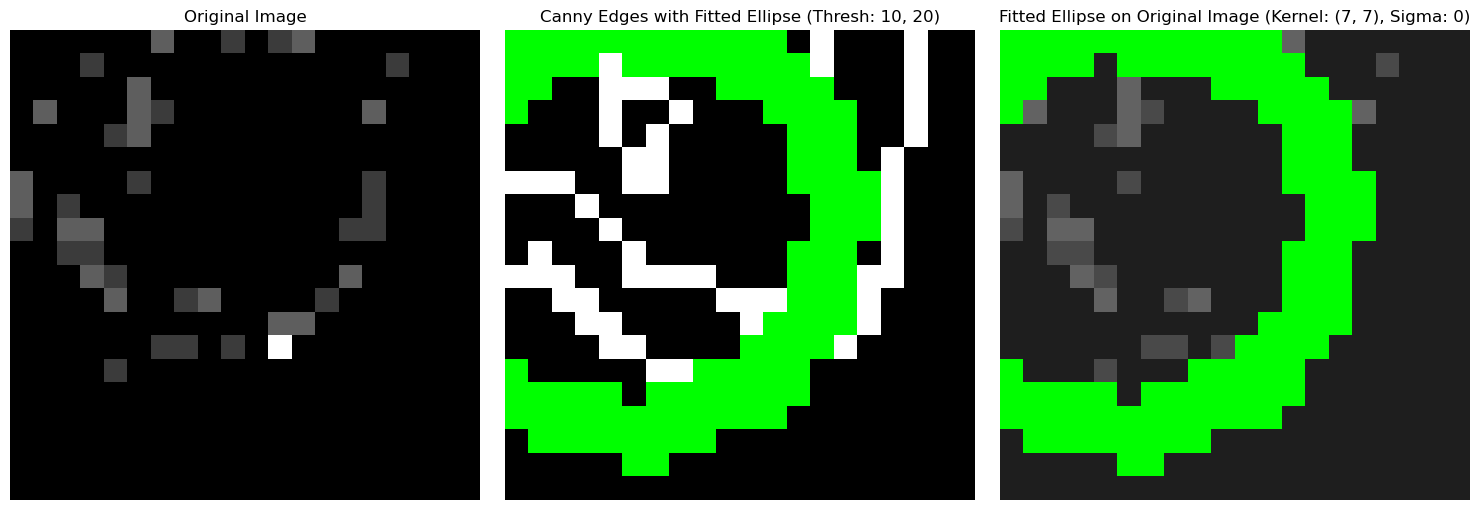

Kernel (7, 7), Sigma 0, Thresholds (10, 50): Residual = 0.4551


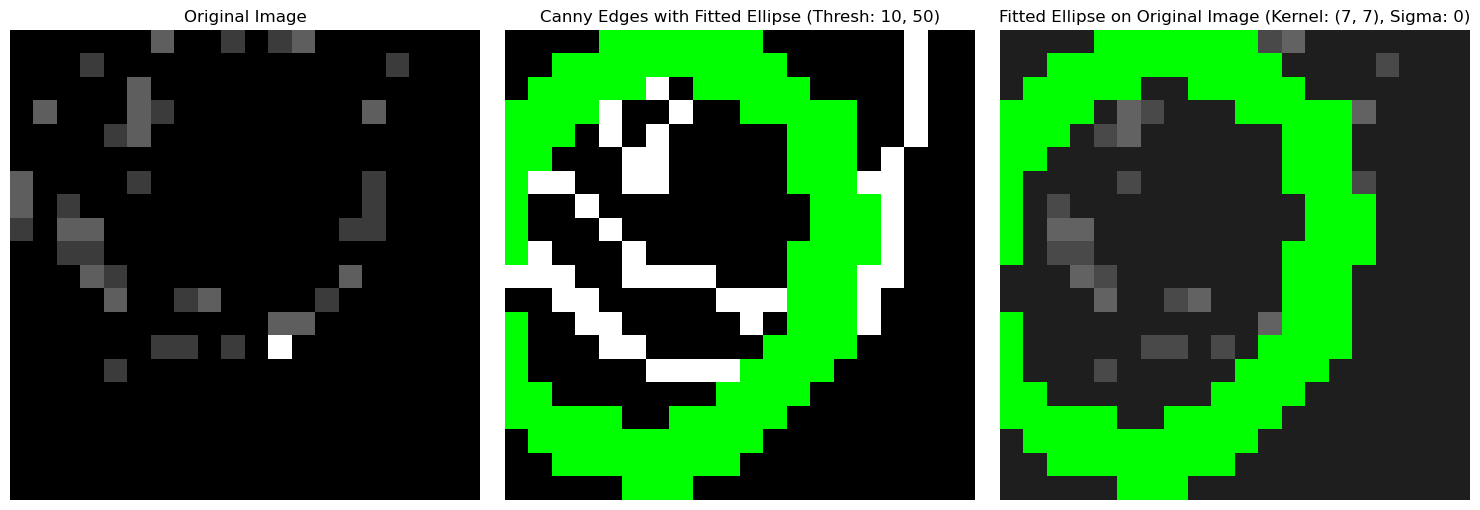

Ellipse fitting failed for kernel (7, 7), sigma 0, thresholds 50, 100.
Kernel (3, 3), Sigma 1, Thresholds (10, 20): Residual = 0.3490


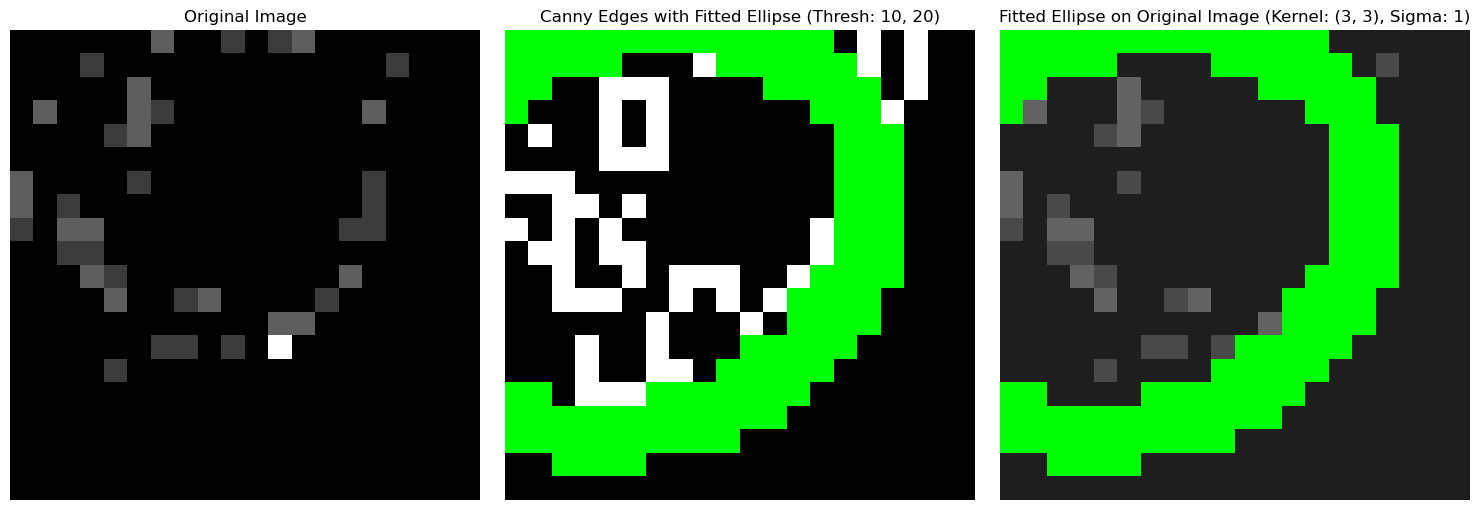

Kernel (3, 3), Sigma 1, Thresholds (10, 50): Residual = 0.3490


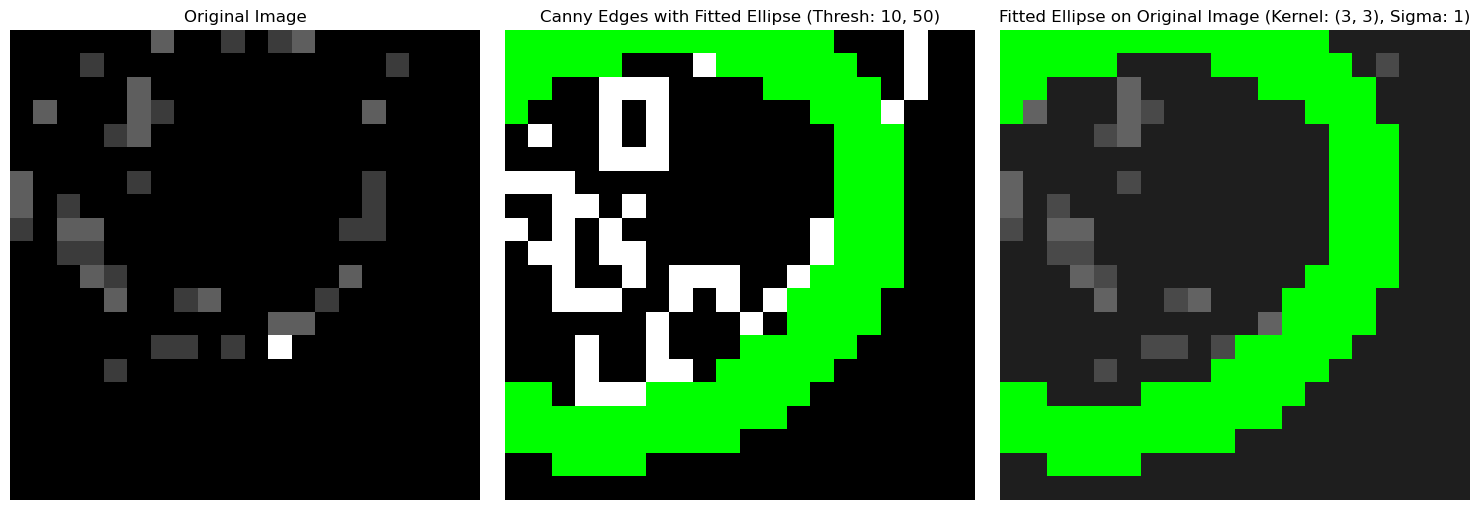

Kernel (3, 3), Sigma 1, Thresholds (50, 100): Residual = 0.4343


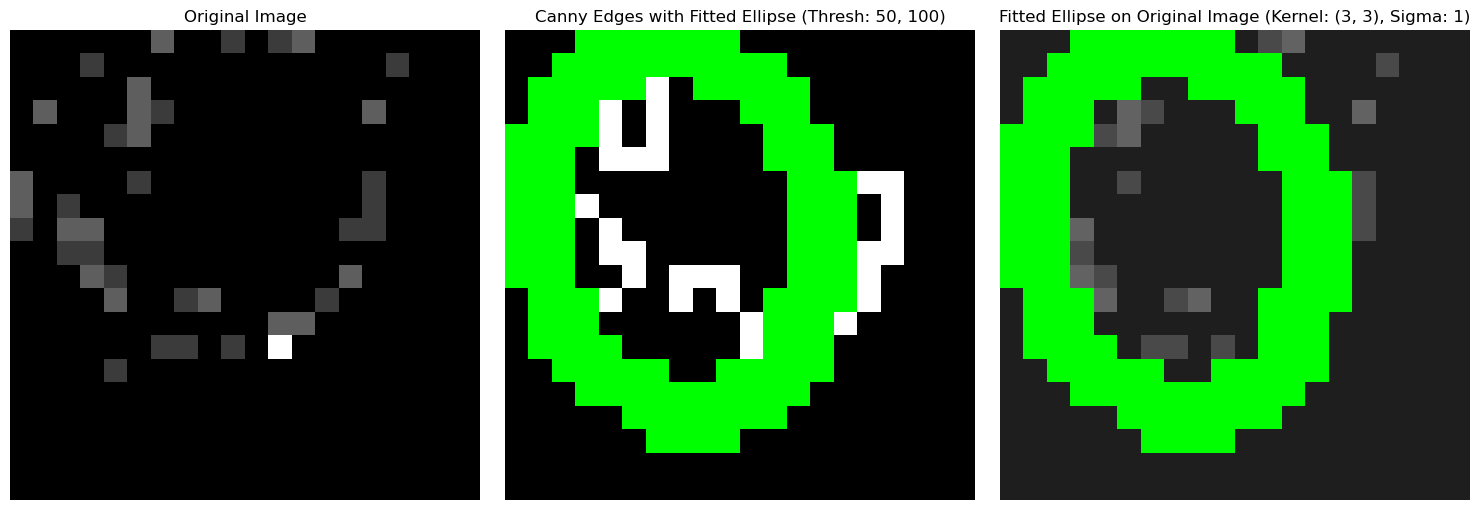

Kernel (5, 5), Sigma 1, Thresholds (10, 20): Residual = 0.3496


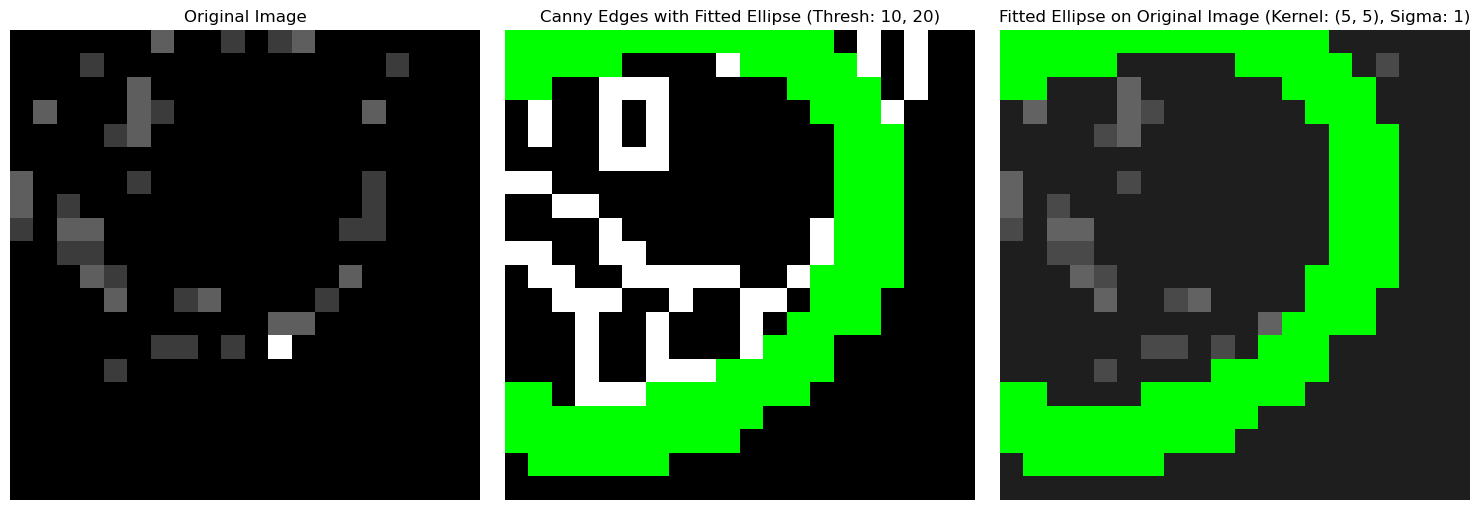

Kernel (5, 5), Sigma 1, Thresholds (10, 50): Residual = 0.3114


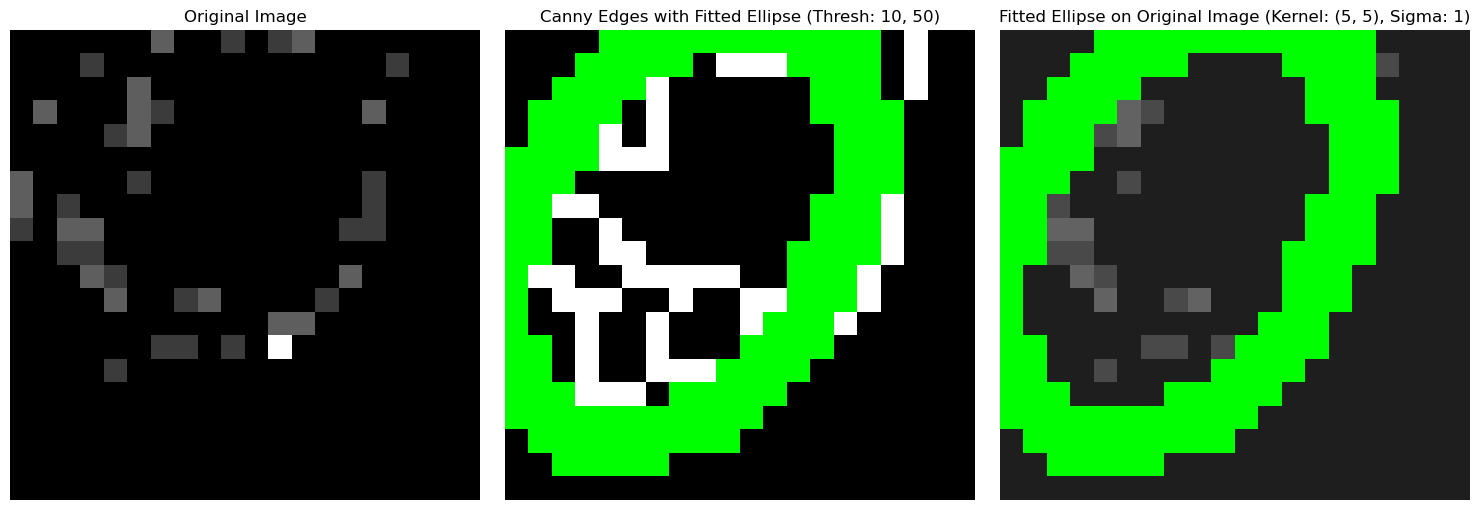

Kernel (5, 5), Sigma 1, Thresholds (50, 100): Residual = 0.4380


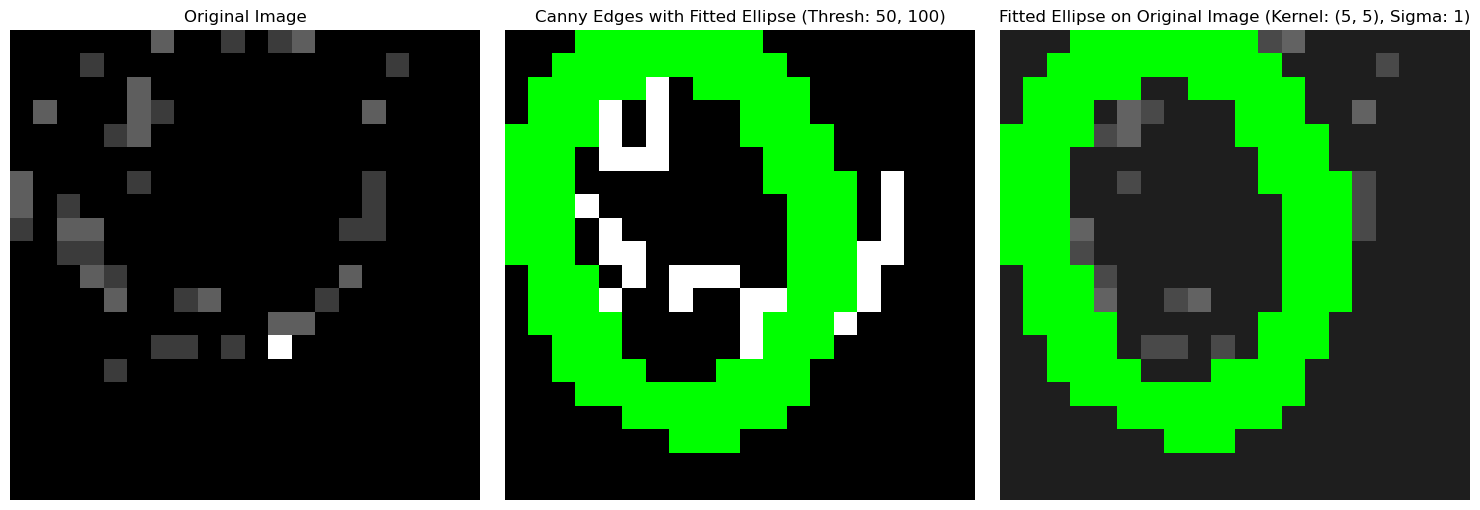

Kernel (7, 7), Sigma 1, Thresholds (10, 20): Residual = 0.3496


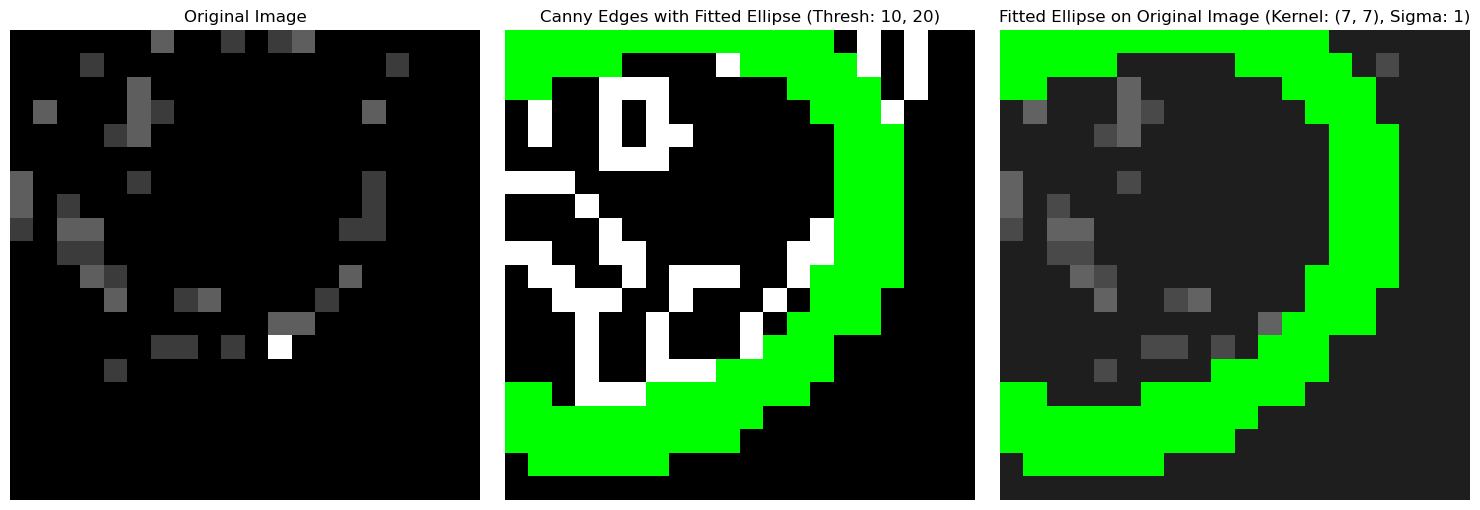

Kernel (7, 7), Sigma 1, Thresholds (10, 50): Residual = 0.3086


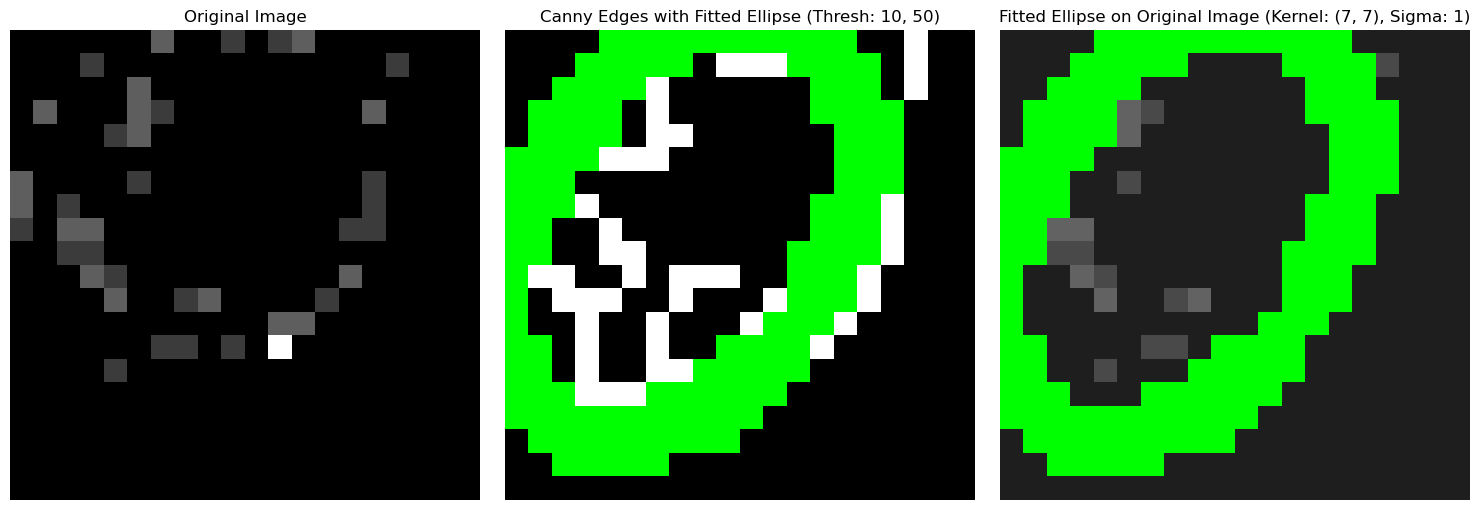

Kernel (7, 7), Sigma 1, Thresholds (50, 100): Residual = 0.4380


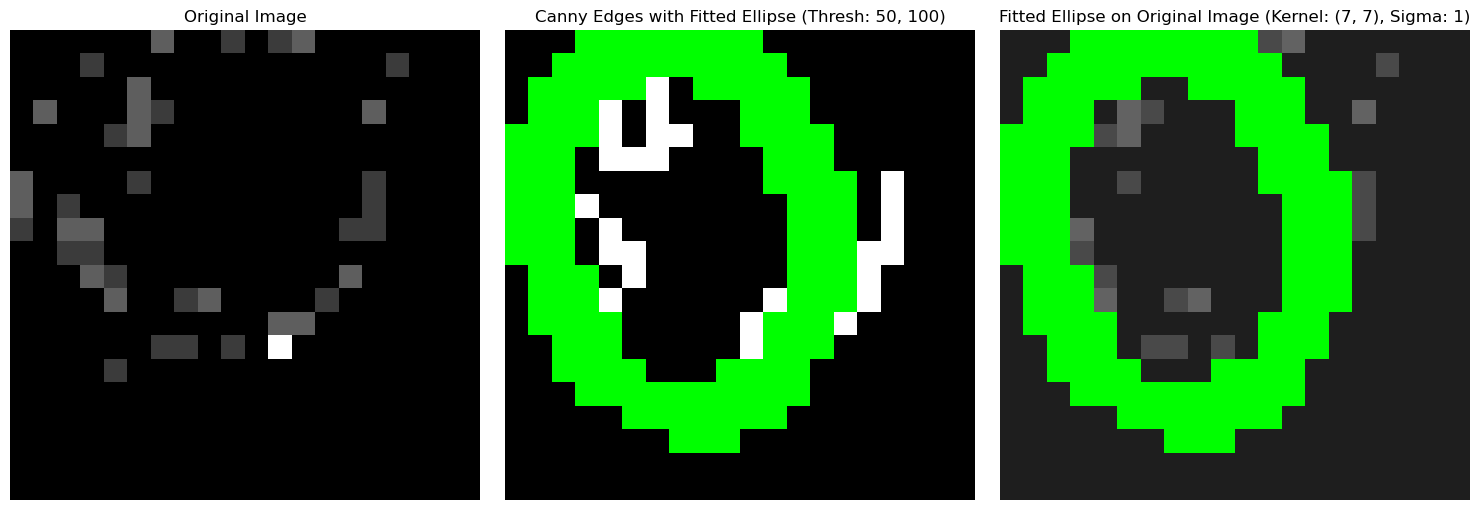

Best parameters based on residuals: Kernel (3, 3), Sigma 0, Thresholds 50, 100 with residual 0.2711


In [26]:
result_folder = "C:\\Users\\yazee\\Test-Figure\\Results"
image_path = "C:\\Users\\yazee\\Test-Figure\\Ellipes_angle_0_degree_pos_X_0_Y_0_Z_20_Energy_1_5_Mev_PMMA_14_mm_20240827_221812_EventID_1.png"

Paths = [result_folder]
for path in Paths:
    if not os.path.exists(path):
        print(f"Path {path} does not exist. Creating it ...")
        os.makedirs(path)

image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
canny_thresholds = [(10, 20), (10, 50), (50, 100)]

gaussian_blur_params = [
    ((3, 3), 0),
    ((5, 5), 0),
    ((7, 7), 0),
    ((3, 3), 1),
    ((5, 5), 1),
    ((7, 7), 1)
]

best_thresholds = None
best_residual = float('inf')

results = []

for kernel_size, sigma in gaussian_blur_params:
    blurred_image = cv2.GaussianBlur(image, kernel_size, sigma)
    
    for low_thresh, high_thresh in canny_thresholds:
        edges = cv2.Canny(blurred_image, low_thresh, high_thresh)
        points = np.column_stack(np.where(edges > 0))

        if len(points) > 3:  
            hull = ConvexHull(points)
            points = points[hull.vertices]

        ellipse_model = EllipseModel()
        if ellipse_model.estimate(points):
            xc, yc, a, b, theta = ellipse_model.params
            ellipse = ((int(xc), int(yc)), (int(2*a), int(2*b)), np.degrees(theta))

            residual = calculate_residuals(points, xc, yc, a, b, theta)
            print(f"Kernel {kernel_size}, Sigma {sigma}, Thresholds ({low_thresh}, {high_thresh}): Residual = {residual:.4f}")
            
            results.append((kernel_size, sigma, low_thresh, high_thresh, residual))
            
            if residual < best_residual:
                best_residual = residual
                best_thresholds = (kernel_size, sigma, low_thresh, high_thresh)

            output_image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
            cv2.ellipse(output_image, ellipse, (0, 255, 0), 2)
            
            contour_image = cv2.cvtColor(edges, cv2.COLOR_GRAY2BGR)
            cv2.ellipse(contour_image, ellipse, (0, 255, 0), 2)
            
            output_file_path_original = os.path.join(result_folder, f"fitted_ellipse_blur_{kernel_size[0]}x{kernel_size[1]}_sigma_{sigma}_thresh_{low_thresh}_{high_thresh}.png")
            output_file_path_contour = os.path.join(result_folder, f"fitted_ellipse_contour_blur_{kernel_size[0]}x{kernel_size[1]}_sigma_{sigma}_thresh_{low_thresh}_{high_thresh}.png")
            cv2.imwrite(output_file_path_original, output_image)
            cv2.imwrite(output_file_path_contour, contour_image)

            plt.figure(figsize=(15, 5))

            # Original Image
            plt.subplot(1, 3, 1)
            plt.imshow(image, cmap='gray')
            plt.title('Original Image')
            plt.axis('off')

            # Canny Edges with Fitted Ellipse
            plt.subplot(1, 3, 2)
            plt.imshow(cv2.cvtColor(contour_image, cv2.COLOR_BGR2RGB))
            plt.title(f'Canny Edges with Fitted Ellipse (Thresh: {low_thresh}, {high_thresh})')
            plt.axis('off')

            # Fitted Ellipse on Original Image
            plt.subplot(1, 3, 3)
            plt.imshow(cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB))
            plt.title(f'Fitted Ellipse on Original Image (Kernel: {kernel_size}, Sigma: {sigma})')
            plt.axis('off')

            plt.tight_layout()
            plt.show()
        
        else:
            print(f"Ellipse fitting failed for kernel {kernel_size}, sigma {sigma}, thresholds {low_thresh}, {high_thresh}.")

print(f"Best parameters based on residuals: Kernel {best_thresholds[0]}, Sigma {best_thresholds[1]}, Thresholds {best_thresholds[2]}, {best_thresholds[3]} with residual {best_residual:.4f}")